Libraries:

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import numpy as np
from utils.Viterbi import Viterbi
DATA_DIR="data/"
HIDDEN_STATES = 5

Data and parameters:

In [97]:
data = pd.read_csv(f"{DATA_DIR}hulls_every2_matchday2.csv")
data = data.dropna()
events=pd.read_csv(f"{DATA_DIR}matchday2_events.csv")
goals_info=events[events["Subtype"].isin(["ON TARGET-GOAL","HEAD-ON TARGET-GOAL","WOODWORK-GOAL"])]
home_goals=goals_info[goals_info["Team"]=="Home"]
away_goals=goals_info[goals_info["Team"]=="Away"]
shots_info=events[events["Type"]=="SHOT"]
home_shot=shots_info[shots_info["Team"]=="Home"]
away_shot=shots_info[shots_info["Team"]=="Away"]

sequence_XY = torch.tensor(data[["HomeHull","AwayHull"]].values/100)

posterior=torch.load(f"parameters/CopulaHMM_matchday2_{HIDDEN_STATES}states_OldData.pt")
initial_state_probs= posterior["probs_initial"]
transition_matrix = posterior["probs_x"]
shape_params1 = posterior["probs_alpha1"]
rate_params1 = posterior["probs_beta1"]
shape_params2 = posterior["probs_alpha2"] 
rate_params2 = posterior["probs_beta2"]
theta= posterior["theta"]

Run Viterbi algorithm:

In [98]:
MLS=Viterbi(observations=sequence_XY,
            initial_states_prob=initial_state_probs,
            transition_matrix=transition_matrix,
            shape_params1=shape_params1,
            rate_params1=rate_params1,
            shape_params2=shape_params2,
            rate_params2=rate_params2,
            theta=theta)
data["State"]=MLS.numpy()

## EPS over time

In [102]:
class_colors = {
    0: 'green',
    1: 'orange',
    2: 'red',
    3: 'blue',
    4: 'purple'
}

In [103]:
def plotEPS_with_states(data : pd.DataFrame,home_goals:pd.DataFrame,away_goals: pd.DataFrame,home_shot: pd.DataFrame,away_shot: pd.DataFrame,class_colors : dict):
    n_states = len(data["State"].unique())
    assert len(class_colors)==n_states
    colors = data['State'].map(class_colors)
    fig, axs = plt.subplots(2, 1, figsize=(36, 12))
    # Home team's convex hull area
    axs[0].vlines(data["Time [s]"]/60, ymin=0, ymax=data["HomeHull"], color=colors, linewidth=0.4)
    axs[0].set_xlabel("Time [min]", fontsize=12,fontweight='normal');
    axs[0].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
    axs[0].set_title("Convex Hull Area over Time (Home team)", fontsize=15, fontweight='bold');
    # add legend
    for i, state in enumerate(list(range(n_states))):
        axs[0].plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')
    axs[0].legend(title="State", title_fontsize='11', fontsize='11', loc='upper right');

    # Away team's convex hull area
    axs[1].vlines(data["Time [s]"]/60, ymin=0, ymax=data["AwayHull"],color=colors, linewidth=0.4)
    axs[1].set_xlabel("Time [min]", fontsize=12,fontweight='normal');
    axs[1].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
    axs[1].set_title("Convex Hull Area over Time (Away team)", fontsize=15, fontweight='bold');
    for i, state in enumerate(list(range(n_states))):
        axs[1].plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')
    axs[1].legend(title="State", title_fontsize='11', fontsize='11', loc='upper right');
    # add vertical lines for home shots
    for t1,t2 in zip(home_shot["Start Time [s]"]/60,home_shot["End Time [s]"]/60):
        axs[0].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=2.5) 
        axs[1].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=2.5)
    for t1,t2 in zip(away_shot["Start Time [s]"]/60,away_shot["End Time [s]"]/60):
        axs[0].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=2.5) 
        axs[1].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=2.5)
    # # add vertical lines for home goals
    for t1,t2 in zip(home_goals["Start Time [s]"]/60,home_goals["End Time [s]"]/60):
        axs[0].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='-', linewidth=3) 
        axs[1].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='-', linewidth=3)
    # add vertical lines for away goals
    for t1,t2 in zip(away_goals["Start Time [s]"]/60,away_goals["End Time [s]"]/60):
        axs[0].axvline(x=(t1+t2)/2, color='black', linestyle='-', linewidth=3) 
        axs[1].axvline(x=(t1+t2)/2, color='black', linestyle='-', linewidth=3)
    # Manage space between subplots
    plt.subplots_adjust(hspace=0.3)
    plt.close(fig)
    return fig

    
    

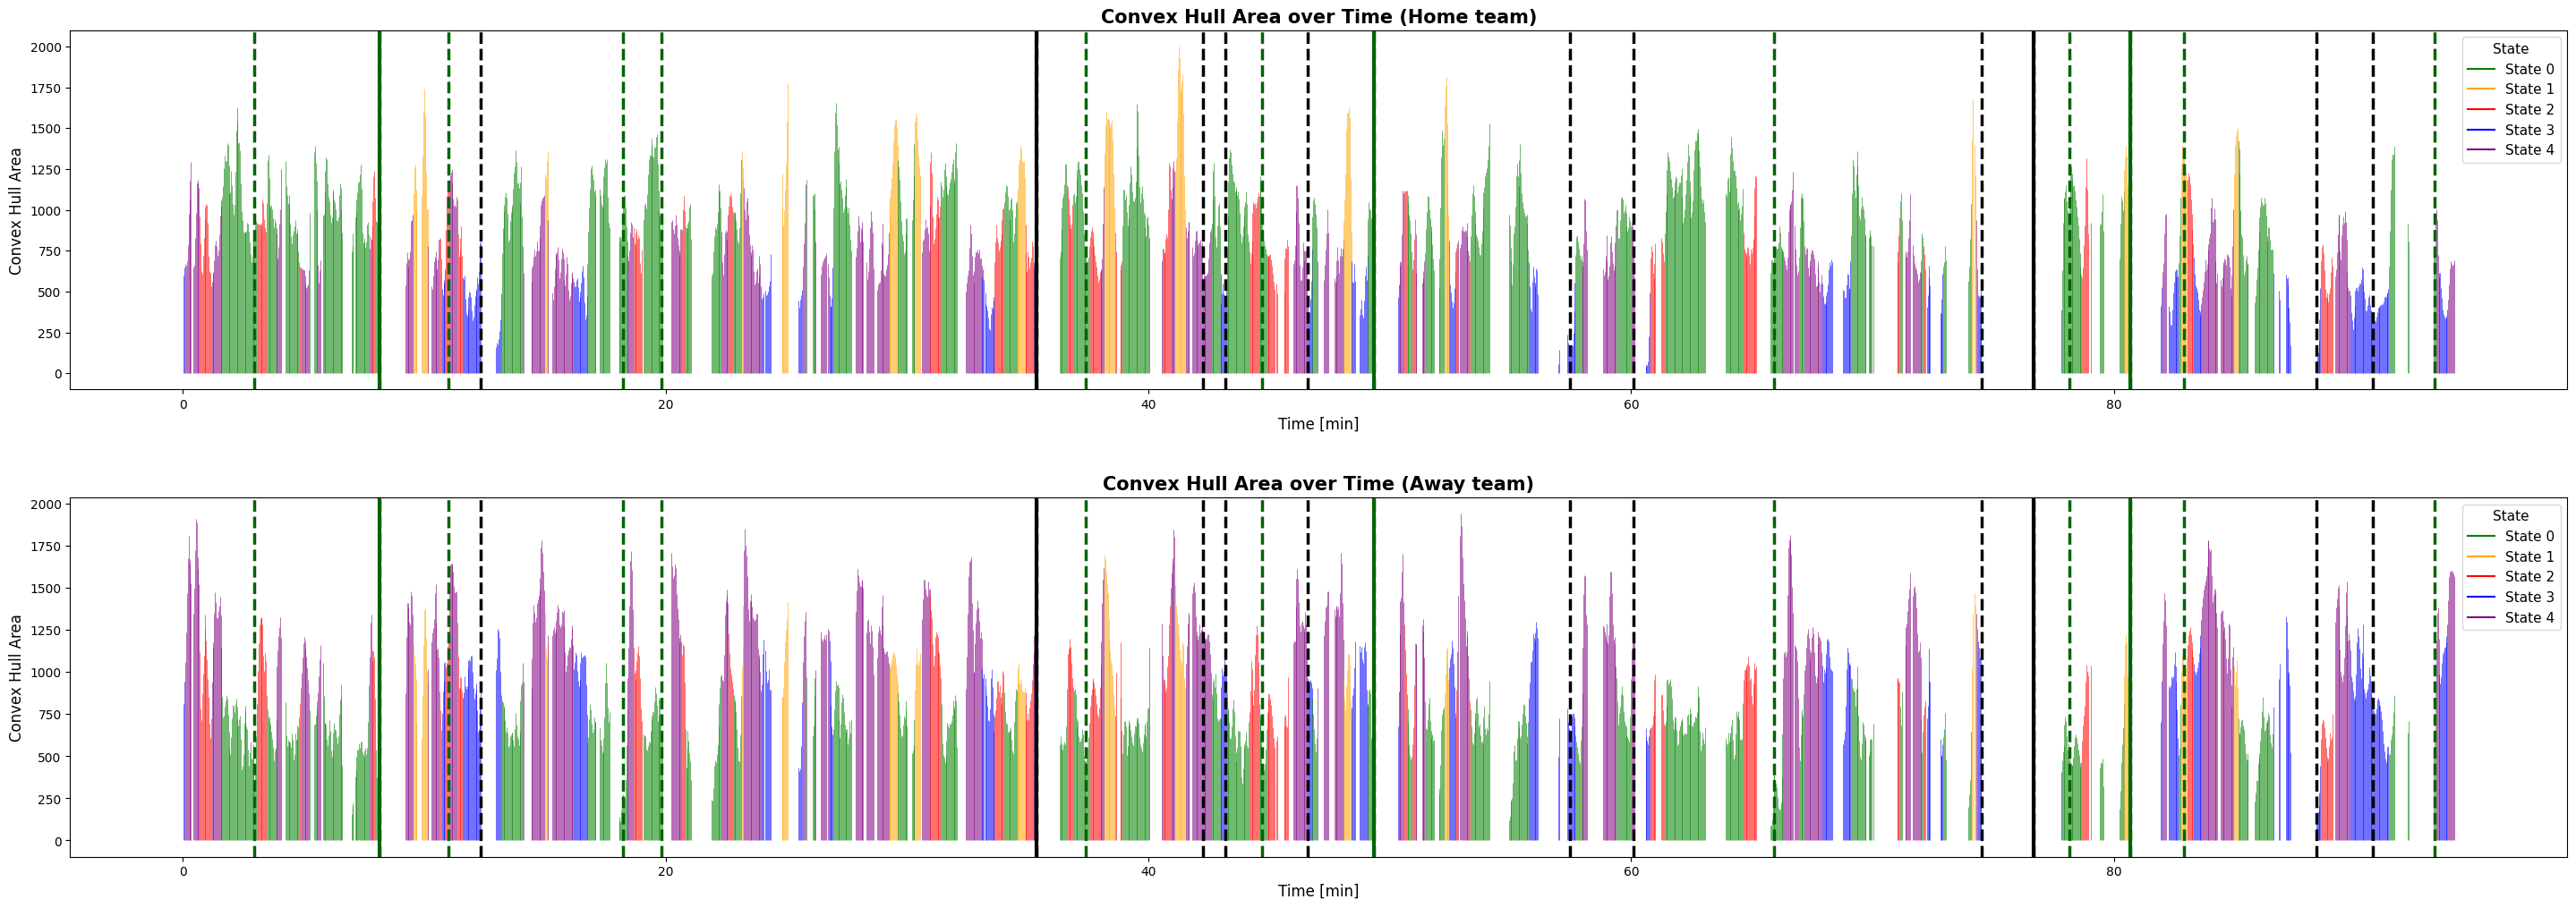

In [105]:
p=plotEPS_with_states(data,home_goals,away_goals,home_shot,away_shot,class_colors)
p

In [106]:
#sns.set_theme(style="whitegrid")
# sns.displot(x=data["HomeHull"], y=data["AwayHull"], hue=data["State"], kind="kde", palette=class_colors)
# plt.title("Bivariate KDE for the Convex Hull Areas of Home and Away Teams (by state)")

def plotEPS_distribution(data, class_colors):
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the KDE plot on the axes
    sns.kdeplot(
        data=data,
        x="HomeHull", 
        y="AwayHull", 
        hue="State", 
        palette=class_colors,
        ax=ax
    )

    # Set the title
    ax.set_title("Bivariate KDE for the Convex Hull Areas of Home and Away Teams (by state)")
    plt.close(fig)
    # Return the figure object
    return fig

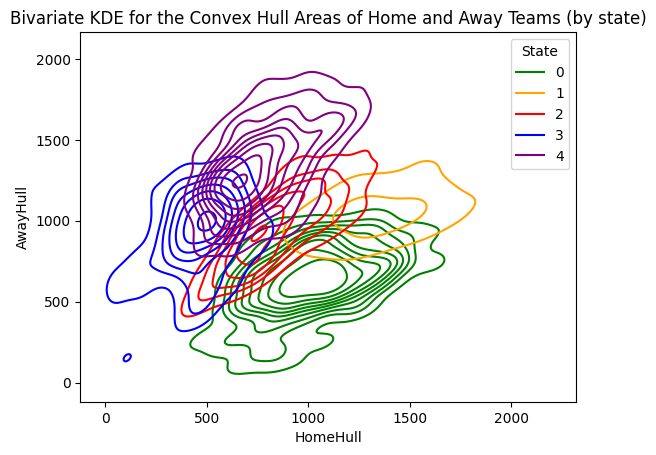

In [107]:
p=plotEPS_distribution(data,class_colors)
p